In [1]:
#Import API
from dora.api import DataExplorer

import pandas as pd
from datetime import date, timedelta, datetime
from matplotlib import pyplot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from uszipcode import ZipcodeSearchEngine
import numpy as np

import random
import time
from sklearn.model_selection import KFold
import json
import sys

explorer = DataExplorer()

In [28]:
def plot3d(X,x,y,z,points,title):
    fig = pyplot.figure()
    ax = Axes3D(fig)
    colors = ['green','red','blue','black','salmon','indigo','plum','seagreen','grey','yellow']
    for i in range(points):
        ax.scatter(X.results[i][x], X.results[i][y],X.results[i][z], c=colors[X.results[i][12]])
    plt.title(title)
    return fig

In [3]:
def custPerCluster(df):
    fig=plt.figure()
    maxn=df['cluster'].max()
    plt.hist(df['cluster'].values)
    plt.xlabel('Clusters')
    plt.ylabel('# of Customers')
    plt.xticks(range(0,maxn+1))
    plt.title('Number of Customers per Cluster')
    return fig

In [4]:
def clusterDist(df):
    maxn=df['cluster'].max()
    clusterStats=pd.DataFrame()
    for i in range(maxn+1):
        mask=(df['cluster']==i)
        t=df.loc[mask]
        clusterStats.loc[i,'avgNumOrders']=t['numorders'].mean()
        clusterStats.loc[i,'avgTotalSpent']=t['totalspent'].mean()
        clusterStats.loc[i,'numHouseholds']=t['householdid'].nunique()
        clusterStats.loc[i,'numZipcoes']=t['zipcode'].nunique()
        clusterStats.loc[i,'avgTotalPopMales']=t['totalmales'].mean()
        clusterStats.loc[i,'avgTotalPopFemales']=t['totalfemales'].mean()
        clusterStats.loc[i,'avgTotalPop']=t['totalpop'].mean()
        clusterStats.loc[i,'medianAge']=t['medianage'].median()
    return clusterStats

In [5]:
def clusterZips(df):
    maxn=df['cluster'].max()
    search = ZipcodeSearchEngine()
    zipstates={}
    zipcities={}
    for i in range(maxn+1):
        #print ("Cluster "+str(i))
        states=set()
        cities=set()
        mask=(df['cluster']==i)
        t=df[['zipcode','cluster']].loc[mask]
        zipcodes=t['zipcode'].unique()
        for j in range(len(zipcodes)):
            city=search.by_zipcode(str(zipcodes[j]))
            cities.add(city['City'])
            states.add(city['State'])
        zipstates.update({i:states})
        zipcities.update({i:cities})
    return zipstates, zipcities

statsByCustomer Query

In [6]:
#statsByCust=explorer.customers.statsByCustomer()
#statsByCustomer=pd.DataFrame(statsByCust.results, columns=statsByCust.columns)
#statsByCustomer.head()

Use the API to get 10 clusters of customers. Bad zipcodes have been removed from the dataset. Customers with no gender assigned are within the dataset of customers to be clustered. A specified feature_set is not defined by the user, neither are the features that will be used for the clustering. In this case, the feature_set will be the data from statsByCustomer and the features will be [numOrders, gender, totalpop, totalspent]. 

In [7]:
#Get 10 clusters and print out the head of the dataframe
cCluster=explorer.customers.clusterCustomers(n_clusters=10,
                                             cluster_on=['gender','totalmales','totalfemales','totalpop'])

In [8]:
#Lists the columns of the cCluster
cCluster.columns

array(['gender', 'totalmales', 'totalfemales', 'totalpop',
       'customermatchedid', 'numorders', 'zipcode', 'medianage',
       'totalspent', 'householdid', 'firstname', 'numcustomerid',
       'cluster', 'customerids'], dtype=object)

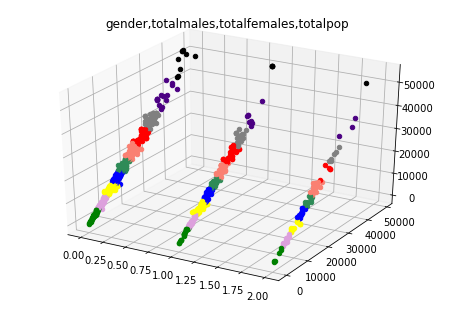

In [29]:
#3-D Plot of the customer clusters (gender, medianage, totalpop)
plot=plot3d(cCluster, 0, 1, 2, 1000,'gender,totalmales,totalfemales,totalpop')
plot

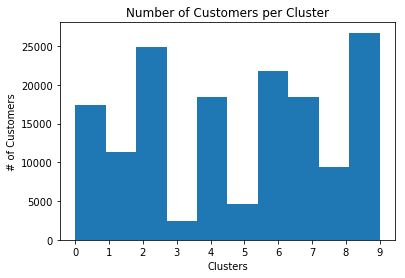

In [10]:
#Histogram of the number of customers in each cluster
df=pd.DataFrame(cCluster.results, columns=cCluster.columns)
dist=custPerCluster(df)
dist

In [11]:
df.head()

,gender,totalmales,totalfemales,totalpop,customermatchedid,numorders,zipcode,medianage,totalspent,householdid,firstname,numcustomerid,cluster,customerids
0,0,12687,9726,22413,37917,412,10036,38.8,606.25,19885296,MIKE,412,9,"(121478, 121471, 121477, 121476, 121475, 12147..."
1,1,12687,9726,22413,37907,189,10036,38.8,651.59,19885296,HILDA,189,9,"(126355, 126362, 126361, 126352, 126360, 12635..."
2,0,12687,9726,22413,140299,99,10036,38.8,0.00,49927024,MIKE,99,9,"(67973, 67961, 67967, 67966, 67965, 67960, 679..."
3,2,12687,9726,22413,37901,99,10036,38.8,2226.32,19885296,,99,9,"(46400, 46407, 46406, 46405, 46404, 46403, 463..."
4,0,12687,9726,22413,140298,70,10036,38.8,0.00,49927024,JIM,70,9,"(68239, 68099, 68245, 68091, 68090, 68094, 680..."


In [12]:
np.save('cluster1_df.npy',df)

In [14]:
df_copy = np.load('cluster1_df.npy')

In [17]:
np.save('cluster1_columns.npy',cCluster.columns)

In [18]:
cols = np.load('cluster1_columns.npy')

In [31]:
# Create co-occurrence matrix

def create_cocmatrix(subset_matrix_cust_order):
    rows, cols = subset_matrix_cust_order.shape
    m = np.zeros((cols,cols))
    
    for i in range(cols):
        t = np.sum(subset_matrix_cust_order[subset_matrix_cust_order[:,i] > 0],axis=0)
        t[i] = 0
        m[i,:] = t
                    
    return m

def create_seed(rand):
    np.random.seed(rand) # create seed for repeatable results

# generate recommendations
# purchase_vec = customer purchases (vector)
# cocm = co occurrence matrix [items x items]
# num_rec = number of recommendations
def gen_recom(purchase_list,cocm,num_rec):
    rowsum = np.zeros(cocm.shape[0])
    
    for p in purchase_list:
        rowsum += cocm[p,:]
        
    rowsum[purchase_list] = 0
    indices = np.nonzero(rowsum)[0]
    toprec = indices[np.argsort(rowsum[indices])][-1 * num_rec:][::-1]
    return toprec

def get_indices(dataset, col, var=None):
    if var is None:
        return [y for y, x in enumerate(dataset[:,col])] # all
    
    return [y for y, x in enumerate(dataset[:,col]) if x == var]

def check_idx_size(idxlist,maximum_rows):
    if len(idxlist) > maximum_rows:
        return np.random.choice(idxlist, maximum_rows, replace=False)
    
    return idxlist

# customer to order lookup
dirname = '/Users/jc/Documents/DSE/joh112/dse203-group-project/machine_learning/ValidationTests/FinalTesting'
matrix_co = np.load("{0}/cust_item_matrix.npy".format(dirname))
print ("created customer to order lookup")

matrix_co.shape

custlist = np.load("{0}/custids.npy".format(dirname))
print ("created customer id lookup")

custlist.shape

created customer to order lookup
created customer id lookup


(189559,)

In [36]:
!pwd

/Users/jc/Documents/DSE/joh112/dse203-group-project/machine_learning/ValidationTests/FinalTesting


In [33]:
unique_clusters = sorted(df['cluster'].unique())
print (unique_clusters)

# bring in customerids to map with cluster ids
arr_cxd = np.zeros((custlist.shape[0],1))

arr_cxd.shape

# mapping cluster ids
for i in range(df.shape[0]):
    for c in df.loc[i,'customerids']:
        idx = np.where(custlist==c)
        cid = df.loc[i,'cluster']
        arr_cxd[idx] = cid+1 # increment by 1 so we can reserve 0 for customers with no cluster id
    

maxn=df['cluster'].max()
print (maxn)

unique_clusters = unique_clusters + [maxn+1]
print (unique_clusters)

#80/20, 80 for 10-fold cross validation, 20 for test set holdout
create_seed(0)
indices = np.random.permutation(matrix_co.shape[0])
tsize = int(matrix_co.shape[0]*.8)

# customer to order matrix
matrix_co_training_idx, matrix_co_testing_idx  = indices[:tsize], indices[tsize:]
matrix_co_training, matrix_co_testing = matrix_co[matrix_co_training_idx,:], matrix_co[matrix_co_testing_idx,:]

# demo matrix
arr_cxd_training_idx, arr_cxd_testing_idx = indices[:tsize], indices[tsize:]
arr_cxd_training, arr_cxd_testing = arr_cxd[arr_cxd_training_idx,:], arr_cxd[arr_cxd_testing_idx,:]

matrix_co_training.shape, arr_cxd_training.shape, matrix_co.shape, arr_cxd.shape

# put matrixes in to get cross validation recall
# generate recommendations
# mco = matrix of customer to order [customer x items]
# num_rec = number of recommendations
# num_folds = k number of folds for cross validation
# recall_remove = removed number from purchase history
def collab_recall_validation_tester(mco,num_rec,num_folds,recall_remove):
    # cross validation n-folds
    start_time = time.time()
    kf = KFold(n_splits=num_folds)
    list_total_acc=[]
    k_index = 0
    
    for train, test in kf.split(mco):
        print("start new k={0},train set={1},validation set={2}".format(k_index,mco[train].shape[0],mco[test].shape[0]))
        
        list_sub_acc = []
        # build co-occurrence matrix
        coo_matrix = create_cocmatrix(mco[train])

        # loop through test set
        # for each customer in test pool
        for i in range(mco[test].shape[0]):
            
            p_vec = mco[test][i,:]
            list_original_purchases = np.where(p_vec > 0)[0]
            # only run tests on customers with > recall_remove purchases for prediction
            if len(list_original_purchases) > recall_remove:
                # randomly select indexes to leave out
                list_removed_purchases = random.sample(list(list_original_purchases),recall_remove)
                # remove
                list_modified_purchases = list(set(list_original_purchases) - set(list_removed_purchases))
                # get sum all purchases except ones left out
                list_summed_coo_vec = gen_recom(list_modified_purchases,coo_matrix,num_rec)
                # check if return recommendations are in list
                list_recommended_match = set(list_removed_purchases) & set(list_summed_coo_vec)
                acc = len(list_recommended_match)/float(len(list_removed_purchases))
                list_sub_acc.append(acc)
                
        mean_sub_acc = np.mean(list_sub_acc)
        print ("** number of elements in calculation {0}".format(len(list_sub_acc)))
        #print list_sub_acc
        print ("** average fold accuracy {0}".format(mean_sub_acc))
        list_total_acc.append(mean_sub_acc)
        k_index += 1
        print ("**time elapsed {0}".format((time.time() - start_time)))
        print ("------------------------------------end")
        
    print ("list of total accuracy for each fold {0}".format(list_total_acc))
    average = np.mean(list_total_acc)
    print ("{0}-fold total average {1}".format(num_folds,average))
    print ("time elapsed {0}".format((time.time() - start_time)))
    return average

# put matrixes in to get cross validation coverage
# generate recommendations
# mco = matrix of customer to order [customer x items]
# num_rec = number of recommendations
# num_folds = k number of folds for cross validation
# recall_remove = removed number from purchase history
# list_catid = category customer is interested in
def collab_catalog_validation_tester(mco,num_rec,num_folds,recall_remove):
    # cross validation n-folds
    start_time = time.time()
    kf = KFold(n_splits=num_folds)
    list_total_coverage=[]
    k_index = 0
    
    for train, test in kf.split(mco):
        set_products = set()
        # build co-occurrence matrix
        print("start new k={0},train set={1},validation set={2}".format(k_index,mco[train].shape[0],mco[test].shape[0]))
        coo_matrix = create_cocmatrix(mco[train])

        # loop through test set
        # for each customer in test pool
        for i in range(mco[test].shape[0]):
            # purchase vector
            p_vec = mco[test][i,:]
            list_original_purchases = np.where(p_vec > 0)[0]
            # get sum all purchases
            list_summed_coo_vec = gen_recom(list_original_purchases,coo_matrix,num_rec)    
            set_products = set_products | set(list_summed_coo_vec)
                        
        mean_sub_cov = float(len(set_products))/p_vec.shape[0]
        print ("**length fold set {0}".format(float(len(set_products))))
        print ("**average fold coverage {0}".format(mean_sub_cov))
        list_total_coverage.append(mean_sub_cov)
        k_index += 1
        print ("**time elapsed {0}".format((time.time() - start_time)))
        print ("------------------------------------end")
    
    print ("list of total coverage for each fold {0}".format(list_total_coverage))
    average = np.mean(list_total_coverage)
    print ("{0}-fold total average {1}".format(num_folds,average))
    print ("time elapsed {0}".format((time.time() - start_time)))
    return average

def demo_filter(mco,mdo,clusters,maximum_rows,minimum_rows,num_rec,num_folds,recall_remove):
    accuracy = []
    coverage = []
    
    for c in clusters:
        #if r == 0: # 0 means not found in the cluster
        #    ridx = get_indices(mdo, 0) # use all regions
        #else:   
        cidx = get_indices(mdo, 0, c) # look for cluster in col 0

        if len(cidx) == 0:
            print ("cluster: {0} not found".format(c))
            continue

        if len(cidx) < minimum_rows:
            print ("too little data with cluster {0} found".format(c))
            continue

        cidx = check_idx_size(cidx,maximum_rows) # limit size
        print ("\ncluster: {0}, size: {1}, {2}".format(c, len(cidx), len(mco)))
                             
        total_accuracy = collab_recall_validation_tester(mco[cidx],num_rec,num_folds,recall_remove)
        accuracy.append((c,mco[cidx].shape[0],total_accuracy))
        total_coverage = collab_catalog_validation_tester(mco[cidx],num_rec,num_folds,recall_remove)
        coverage.append((c,mco[cidx].shape[0],total_coverage))
        
    return accuracy, coverage

# General test
seed = 0
create_seed(seed)
maximum_rows = 25000
minimum_rows = 1000


# big set
demo_accuracy, demo_coverage = demo_filter(matrix_co_training,arr_cxd_training,\
                                   unique_clusters,maximum_rows,minimum_rows,10,10,1)

#demo_accuracy

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
9
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

cluster: 0, size: 3222, 151647
start new k=0,train set=2899,validation set=323
** number of elements in calculation 88
** average fold accuracy 0.4659090909090909
**time elapsed 1.8388299942016602
------------------------------------end
start new k=1,train set=2899,validation set=323
** number of elements in calculation 92
** average fold accuracy 0.40217391304347827
**time elapsed 3.7037758827209473
------------------------------------end
start new k=2,train set=2900,validation set=322
** number of elements in calculation 83
** average fold accuracy 0.5180722891566265
**time elapsed 5.238719940185547
------------------------------------end
start new k=3,train set=2900,validation set=322
** number of elements in calculation 98
** average fold accuracy 0.46938775510204084
**time elapsed 6.743157863616943
------------------------------------end
start new k=4,train set=2900,validation set=322
** number of elements in cal

start new k=6,train set=14666,validation set=1629
**length fold set 623.0
**average fold coverage 0.156140350877193
**time elapsed 203.75492787361145
------------------------------------end
start new k=7,train set=14666,validation set=1629
**length fold set 624.0
**average fold coverage 0.15639097744360902
**time elapsed 231.9880678653717
------------------------------------end
start new k=8,train set=14666,validation set=1629
**length fold set 634.0
**average fold coverage 0.15889724310776943
**time elapsed 260.8415629863739
------------------------------------end
start new k=9,train set=14666,validation set=1629
**length fold set 629.0
**average fold coverage 0.15764411027568923
**time elapsed 289.17909502983093
------------------------------------end
list of total coverage for each fold [0.15889724310776943, 0.15889724310776943, 0.15213032581453634, 0.16666666666666666, 0.16265664160401003, 0.1631578947368421, 0.156140350877193, 0.15639097744360902, 0.15889724310776943, 0.1576441102

**length fold set 694.0
**average fold coverage 0.17393483709273183
**time elapsed 62.81538009643555
------------------------------------end
start new k=1,train set=21221,validation set=2358
**length fold set 692.0
**average fold coverage 0.17343358395989975
**time elapsed 129.4776861667633
------------------------------------end
start new k=2,train set=21221,validation set=2358
**length fold set 666.0
**average fold coverage 0.16691729323308271
**time elapsed 195.02286529541016
------------------------------------end
start new k=3,train set=21221,validation set=2358
**length fold set 659.0
**average fold coverage 0.16516290726817043
**time elapsed 260.3608193397522
------------------------------------end
start new k=4,train set=21221,validation set=2358
**length fold set 699.0
**average fold coverage 0.17518796992481203
**time elapsed 325.42226004600525
------------------------------------end
start new k=5,train set=21221,validation set=2358
**length fold set 666.0
**average fold cove

start new k=7,train set=15853,validation set=1761
** number of elements in calculation 472
** average fold accuracy 0.6165254237288136
**time elapsed 276.09616112709045
------------------------------------end
start new k=8,train set=15853,validation set=1761
** number of elements in calculation 444
** average fold accuracy 0.5855855855855856
**time elapsed 308.8488709926605
------------------------------------end
start new k=9,train set=15853,validation set=1761
** number of elements in calculation 467
** average fold accuracy 0.6145610278372591
**time elapsed 342.2457809448242
------------------------------------end
list of total accuracy for each fold [0.61339092872570189, 0.55252100840336138, 0.58279569892473115, 0.61521739130434783, 0.63774403470715835, 0.60084033613445376, 0.61084905660377353, 0.61652542372881358, 0.5855855855855856, 0.61456102783725908]
10-fold total average 0.6030030491955185
time elapsed 342.2474579811096
start new k=0,train set=15852,validation set=1762
**leng

start new k=2,train set=18802,validation set=2089
** number of elements in calculation 554
** average fold accuracy 0.6119133574007221
**time elapsed 139.78959918022156
------------------------------------end
start new k=3,train set=18802,validation set=2089
** number of elements in calculation 562
** average fold accuracy 0.6103202846975089
**time elapsed 186.50129914283752
------------------------------------end
start new k=4,train set=18802,validation set=2089
** number of elements in calculation 572
** average fold accuracy 0.5996503496503497
**time elapsed 233.61281418800354
------------------------------------end
start new k=5,train set=18802,validation set=2089
** number of elements in calculation 575
** average fold accuracy 0.6365217391304347
**time elapsed 280.15168714523315
------------------------------------end
start new k=6,train set=18802,validation set=2089
** number of elements in calculation 566
** average fold accuracy 0.6466431095406361
**time elapsed 327.2078130245

**length fold set 615.0
**average fold coverage 0.15413533834586465
**time elapsed 293.82841324806213
------------------------------------end
start new k=9,train set=15725,validation set=1747
**length fold set 607.0
**average fold coverage 0.15213032581453634
**time elapsed 326.39832305908203
------------------------------------end
list of total coverage for each fold [0.15664160401002505, 0.1556390977443609, 0.1523809523809524, 0.1536340852130326, 0.15388471177944862, 0.15213032581453634, 0.14962406015037594, 0.15012531328320802, 0.15413533834586465, 0.15213032581453634]
10-fold total average 0.15303258145363408
time elapsed 326.40123891830444

cluster: 9, size: 9003, 151647
start new k=0,train set=8102,validation set=901
** number of elements in calculation 234
** average fold accuracy 0.594017094017094
**time elapsed 9.060942888259888
------------------------------------end
start new k=1,train set=8102,validation set=901
** number of elements in calculation 233
** average fold accur

start new k=3,train set=22500,validation set=2500
**length fold set 734.0
**average fold coverage 0.18395989974937343
**time elapsed 294.2311420440674
------------------------------------end
start new k=4,train set=22500,validation set=2500
**length fold set 707.0
**average fold coverage 0.17719298245614035
**time elapsed 366.41634607315063
------------------------------------end
start new k=5,train set=22500,validation set=2500
**length fold set 746.0
**average fold coverage 0.18696741854636592
**time elapsed 438.6561760902405
------------------------------------end
start new k=6,train set=22500,validation set=2500
**length fold set 756.0
**average fold coverage 0.18947368421052632
**time elapsed 511.14480781555176
------------------------------------end
start new k=7,train set=22500,validation set=2500
**length fold set 759.0
**average fold coverage 0.19022556390977444
**time elapsed 584.5903930664062
------------------------------------end
start new k=8,train set=22500,validation se

In [37]:
np.save('cluster1CustmeridsMapping.npy',arr_cxd)

In [34]:
np.save('demo_cluster_accuracy1.npy',\
        [(maximum_rows,minimum_rows,seed,datetime.now().strftime("%Y-%m-%d_%H:%M:%S"))]+demo_accuracy)

#demo_coverage

np.save('demo_cluster_coverage1.npy',\
        [(maximum_rows,minimum_rows,seed,datetime.now().strftime("%Y-%m-%d_%H:%M:%S"))]+demo_coverage)

In [38]:
demo_accuracy

[(0, 3222, 0.46257478957855691),
 (1, 16295, 0.58170209997236921),
 (2, 10735, 0.57435169354248883),
 (3, 23579, 0.60573060964749637),
 (4, 2279, 0.49089959863893046),
 (5, 17614, 0.6030030491955185),
 (6, 4458, 0.51616169561181546),
 (7, 20891, 0.61594430904584985),
 (8, 17472, 0.59787281550471716),
 (9, 9003, 0.57365191402043703),
 (10, 25000, 0.61728847590159885)]

In [39]:
demo_coverage

[(0, 3222, 0.079398496240601496),
 (1, 16295, 0.15914786967418545),
 (2, 10735, 0.12030075187969924),
 (3, 23579, 0.17002506265664161),
 (4, 2279, 0.051303258145363406),
 (5, 17614, 0.15147869674185463),
 (6, 4458, 0.081629072681704246),
 (7, 20891, 0.16942355889724309),
 (8, 17472, 0.15303258145363408),
 (9, 9003, 0.11914786967418545),
 (10, 25000, 0.18596491228070175)]

In [45]:
# mapping cluster ids
def create_cluster_coo_matrix(mco,arr,clusterid):
    indx = []
    
    for i in range(arr.shape[0]):
        if (arr[i]) == clusterid:
            indx.append(i)

    cluster_coo_matrix = create_cocmatrix(mco[indx])
    np.save("cluster{0}_coo_matrix.npy".format(clusterid),cluster_coo_matrix)

In [46]:
for c in [3,5,7,10]:
    create_cluster_coo_matrix(matrix_co,arr_cxd,c)

In [44]:
!pwd


/Users/jc/Documents/DSE/joh112/dse203-group-project/machine_learning/ValidationTests/FinalTesting
